In [1]:
from PIL import Image
import math
import collections
import pandas as pd
import numpy as np
from numpy.linalg import norm

In [2]:
# picture size factor
factor = 5
# define picture size
width=300 * factor
height=160 * factor
# define sphere radius
r1 = 50 * factor
r2 = 30 * factor
# define sphere color
scolor1 = np.array([1, 1, 0])
scolor2 = np.array([0, 1, 1])
# define flour color
fcolor = np.array([0.9, 0.9, 0.9])
# define ambient light
Iamb = np.array([50, 50, 50])
# define point light
IL = np.array([200, 200, 200])
# define sphere location
sloc1 = np.array([220 * factor, r1, 80 * factor])
sloc2 = np.array([120 * factor, r2, 80 * factor])
# define point light location
ploc = np.array([360 * factor, 200 * factor, 10 * factor])
# eye direction
V = np.array([0, 1, 0])

In [3]:
def convert_to_color(nplist):
    newr = []
    for elem in nplist:
        newr.append(min(255, int(elem)))
    return tuple(newr)

In [4]:
# generate edge points for sphere:
def generate_semisphere_3D(r, sloc):

    r2 = r ** 2
    d = 5/4 - r
    x = 0
    z = r
    points = [[x, 0, z], [z, 0, x]]

    # generate first quarter
    while x < z:
        if d < 0:
            d += 2 * x + 3
        elif d > 0:
            z -= 1
            d += 2 * x - 2 * z - 5

        x = x + 1
        points.append([x, 0, z])
        points.append([z, 0, x])

    points.append([int(r / math.sqrt(2)), 0, int(r / math.sqrt(2))])

    # check if all z have been drawn
    spoints = set([x[2] for x in points])
    for z in range(0, r + 1):
        if z not in spoints:
            print(z)

    # generate rest quarters
    rest = []
    for xq, yq, zq in points:
        rest.append([xq, 0, -zq])
        rest.append([-xq, 0, zq])
        rest.append([-xq, 0, -zq])

    points += rest

    # generate points inside the edge
    # scan line
    zdict = collections.defaultdict(set)
    for x, y, z in points:
        zdict[z].add(x)
    # fill
    for cz, xset in zdict.items():
        xmin = min(xset)
        xmax = max(xset)
        for cx in range(xmin, xmax + 1):
            if cx in xset:
                continue
            points.append([cx, 0, cz])

    # generate y coordinate for all points
    for clist in points:
        y2 = r2 - clist[0] ** 2 - clist[2] ** 2
        if y2 > 0:
            clist[1] = int(math.sqrt(y2))
        else:
            clist[1] = 0

    # relocate
    rpoints = np.array(points)
    rpoints += sloc
    
    return rpoints

In [5]:
rp1 = generate_semisphere_3D(r1, sloc1)
rp2 = generate_semisphere_3D(r2, sloc2)

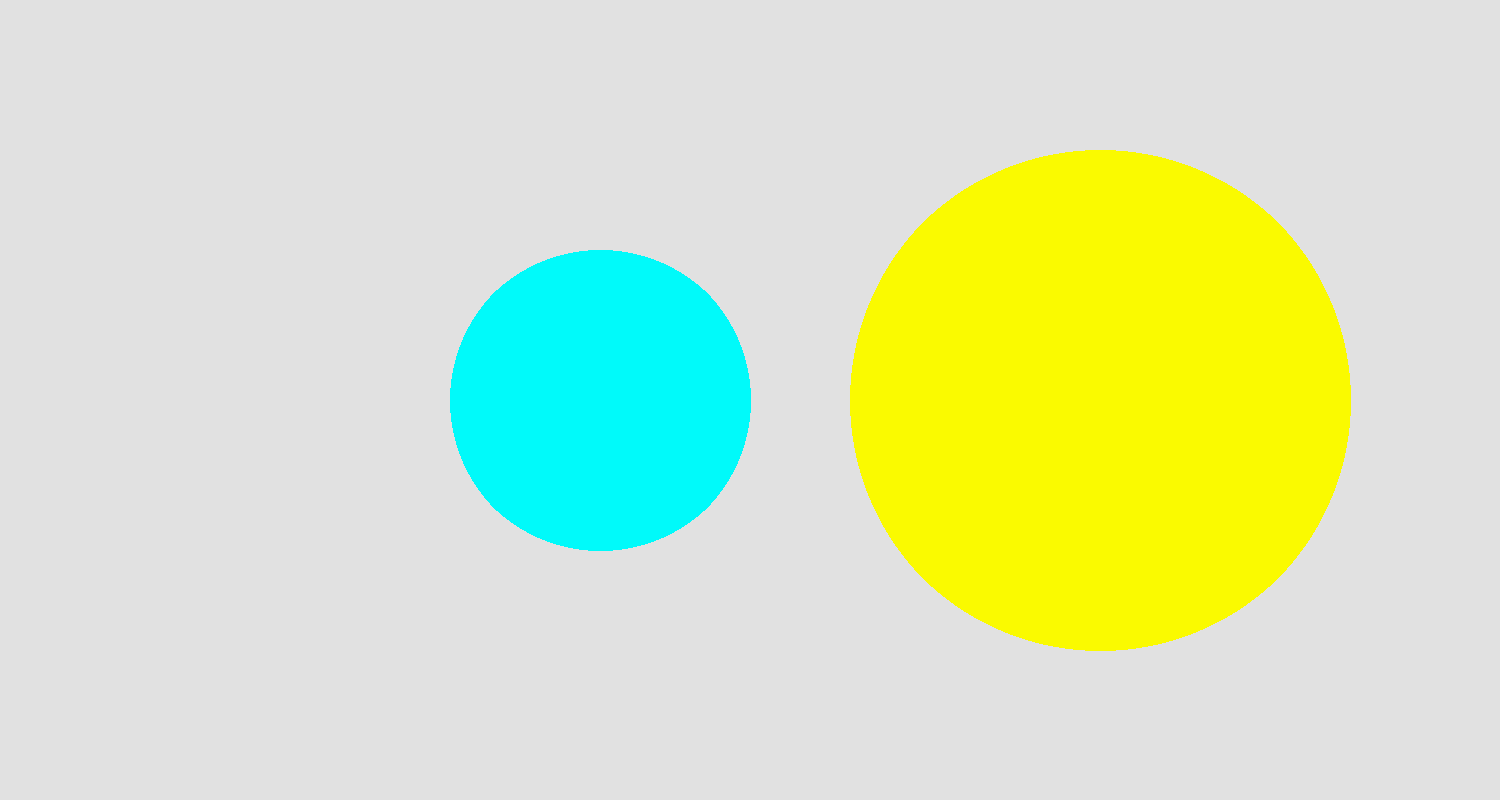

In [6]:
# draw color without light
timg = Image.new('RGB', (width, height))
tpixels = timg.load()
# floor
for x in range(width):
    for z in range(height):
        tpixels[x, z] = convert_to_color((IL + Iamb) * fcolor)
# sphere 1
for x, y, z in rp1:
    tpixels[x, z] = convert_to_color((IL + Iamb) * scolor1)
# sphere 2
for x, y, z in rp2:
    tpixels[x, z] = convert_to_color((IL + Iamb) * scolor2)
timg.show()

In [7]:
def solvingQuadratics(a, b, c):
    delta = b * b - 4 * a * c
    if delta < 0:
        return []

    if abs(delta) < 1e-6:
        return [-b / (2 * a)]
    
    return [(-b + math.sqrt(delta)) / (2 * a), (-b - math.sqrt(delta)) / (2 * a)]

In [8]:
def isBlocked(point, r, sloc):
    
    O = point
    E = ploc
    D = E - O
    Center = sloc

    a = sum(D * D)
    b = 2 * D[0] * (O[0] - Center[0]) + 2 * D[1] * (O[1] - Center[1]) + 2 * D[2] * (O[2] - Center[2])
    c = (O[0] - Center[0]) ** 2 + (O[1] - Center[1]) ** 2 + (O[2] - Center[2]) ** 2 - r ** 2

    for t in solvingQuadratics(a, b, c):
         if t >= 0 and t <= 1:
            return True
    
    return False

In [9]:
def cal_intensity(point, N, isFloor=False, isS2=False):
    
    if isFloor and (isBlocked(point, r1, sloc1) or isBlocked(point, r2, sloc2)):
        return Iamb
    if isS2 and isBlocked(point, r1, sloc1):
        return Iamb
    
    L = ploc - point
    L = L / norm(L, ord=2)
    cos_theta = sum(L * N)
    
    if cos_theta <= 0:
        return Iamb
    
    Idiff = IL * cos_theta
    
    R = 2 * cos_theta * N - L
    R = R / norm(R, ord=2)
    cos_alpha = sum(R * V)
    if cos_alpha <= 0:
        return Iamb + Idiff
    
    Ispec = IL * cos_alpha ** 8
    return Iamb + Idiff + Ispec

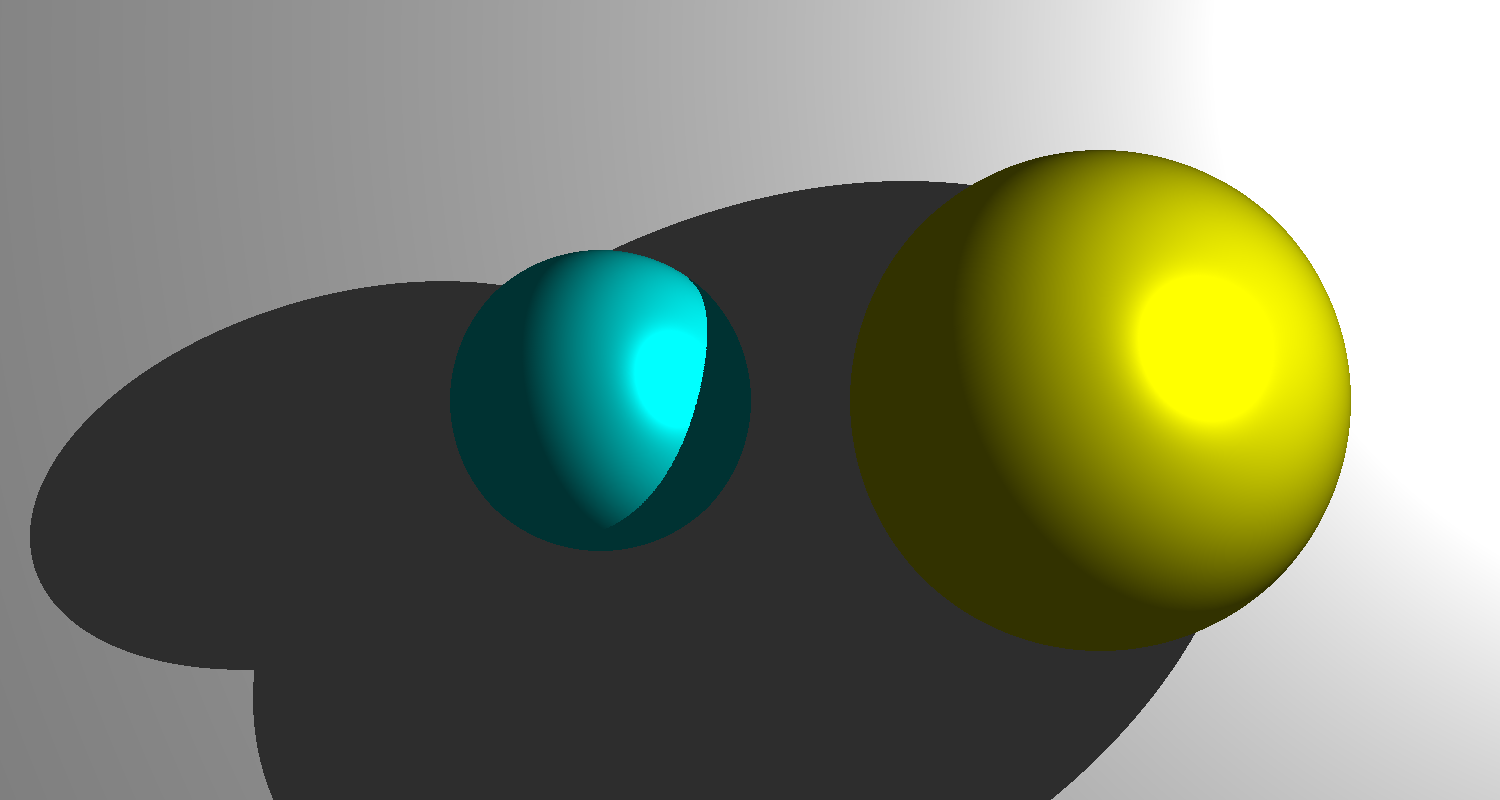

In [10]:
# draw color with light
timg = Image.new('RGB', (width, height))
tpixels = timg.load()
# floor
for x in range(width):
    for z in range(height):
        tpixels[x, z] = convert_to_color(cal_intensity(np.array([x, 0, z]), np.array([0, 1, 0]), isFloor=True) * fcolor)
# sphere 1
for point in rp1:
    normal = point - sloc1
    normal = normal / norm(normal, ord=2)
    tpixels[point[0], point[2]] = convert_to_color(cal_intensity(point, normal) * scolor1)
# sphere 2
for point in rp2:
    normal = point - sloc2
    normal = normal / norm(normal, ord=2)
    tpixels[point[0], point[2]] = convert_to_color(cal_intensity(point, normal, isS2=True) * scolor2)

timg.show()

In [11]:
timg.save('shadow.jpg')